Found celebrity folders: ['./croppeddataset/jack', './croppeddataset/modi', './croppeddataset/musk', './croppeddataset/scott']

Basic model score: 0.9333333333333333
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       0.90      0.95      0.93        40
           2       0.95      0.91      0.93        22
           3       0.94      0.89      0.92        38

    accuracy                           0.93       120
   macro avg       0.94      0.94      0.94       120
weighted avg       0.93      0.93      0.93       120


Grid Search Results:
   model  best_score                             best_params
0   svm    0.943897  {'svc__C': 1, 'svc__kernel': 'linear'}


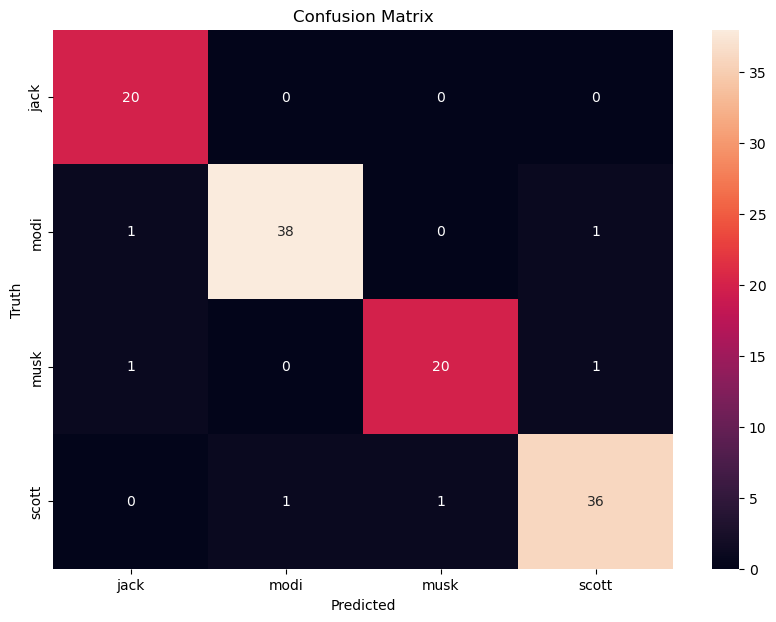


✅ Model training complete!
✅ Model saved to: ./artifacts/saved_model.pkl
✅ Class dictionary saved to: ./artifacts/class_dictionary.json
✅ Confusion matrix image saved to: ./artifacts/confusion_matrix.png


In [3]:
import os
import cv2
import numpy as np
import json
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

import joblib

# ---- Utility Function for Haar Wavelet Transform ----
import pywt

def w2d(img, mode='haar', level=1):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = np.float32(img_gray)
    img_gray /= 255.0
    coeffs = pywt.wavedec2(img_gray, mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0  # Set approximation coefficients to zero
    img_reconstructed = pywt.waverec2(coeffs_H, mode)
    img_reconstructed *= 255
    return np.uint8(img_reconstructed)

# ---- Create trained/ folder if it doesn't exist ----
output_dir = './artifacts'
os.makedirs(output_dir, exist_ok=True)

# ---- Load cropped dataset paths ----
croppeddataset = []
dataset_path = './croppeddataset/'  # Update this if needed

for entry in os.scandir(dataset_path):
    if entry.is_dir():
        croppeddataset.append(entry.path)

print("Found celebrity folders:", croppeddataset)

# ---- Map images by celebrity ----
celebrity_file_names_dict = {}

for img_dir in croppeddataset:
    celebrity_name = os.path.basename(img_dir)
    file_list = []
    for entry in os.scandir(img_dir):
        if entry.is_file():
            file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

# ---- Create class dictionary ----
class_dict = {name: idx for idx, name in enumerate(celebrity_file_names_dict.keys())}

# ---- Prepare training data ----
X, y = [], []

for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is not None:
            try:
                scalled_raw_img = cv2.resize(img, (32, 32))
                img_har = w2d(img, 'db1', 5)
                scalled_img_har = cv2.resize(img_har, (32, 32))
                combined_img = np.vstack(
                    (scalled_raw_img.reshape(32*32*3, 1), scalled_img_har.reshape(32*32, 1))
                )
                X.append(combined_img)
                y.append(class_dict[celebrity_name])
            except Exception as e:
                print(f"Skipping image {training_image}: {e}")

X = np.array(X).reshape(len(X), 4096).astype(float)

# ---- Train/test split ----
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# ---- Basic model ----
pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='rbf', C=10))])
pipe.fit(X_train, y_train)

basic_score = pipe.score(X_test, y_test)
print(f"\nBasic model score: {basic_score}")
print(classification_report(y_test, pipe.predict(X_test)))

# ---- Grid search ----
model_params = {
    'svm': {
        'model': SVC(gamma='auto', probability=True),
        'params': {
            'svc__C': [1, 10, 100, 1000],
            'svc__kernel': ['rbf', 'linear']
        }
    }
}

scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf = GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False, n_jobs=-1)
    clf.fit(X_train, y_train)

    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
print("\nGrid Search Results:\n", df)

# ---- Confusion matrix ----
best_clf = best_estimators['svm']
cm = confusion_matrix(y_test, best_clf.predict(X_test))

plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d',
           xticklabels=list(class_dict.keys()),
           yticklabels=list(class_dict.keys()))
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("Confusion Matrix")
plt.savefig(os.path.join(output_dir, 'confusion_matrix.png'))
plt.show()

# ---- Save model & metadata ----
joblib.dump(best_clf, os.path.join(output_dir, 'saved_model.pkl'))

with open(os.path.join(output_dir, "class_dictionary.json"), "w") as f:
    json.dump(class_dict, f, indent=4)

print("\n✅ Model training complete!")
print(f"✅ Model saved to: {output_dir}/saved_model.pkl")
print(f"✅ Class dictionary saved to: {output_dir}/class_dictionary.json")
print(f"✅ Confusion matrix image saved to: {output_dir}/confusion_matrix.png")
